In [1]:
# Set project root
import os
import sys

# Manually set the path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import json

import cv2
import matplotlib.pyplot as plt
import numpy as np

from src.geometry import recover_pose_from_homography
from src.measurement_data import load_measurements_from_yaml
from src.plotting import draw_3d_axes

## Function definition

In [3]:
def load_calibration_json(filename):
    with open(filename) as f:
        data = json.load(f)

    camera_matrix = np.array(data['camera_matrix'])
    dist_coeff = np.array(data['dist_coeff'])
    image_size = tuple(data['image_size'])

    return camera_matrix, dist_coeff, image_size

In [4]:
def load_rgb(path):
    """
    Load image from path and convert to RGB.
    """
    bgr = cv2.imread(path, cv2.IMREAD_COLOR)
    if bgr is None:
        raise FileNotFoundError(f"Image not found: {path}")
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    return rgb

def extract_features(image, method='SIFT'):
    """
    Detect keypoints and compute descriptors.

    Args:
        image: RGB image as numpy array.
        method: Feature detector ('SIFT', 'ORB', etc.).
    Returns:
        keypoints, descriptors
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    if method == 'SIFT':
        detector = cv2.SIFT_create()
    elif method == 'ORB':
        detector = cv2.ORB_create(nfeatures=2000)
    else:
        raise ValueError(f"Unsupported method: {method}")
    keypoints, descriptors = detector.detectAndCompute(gray, None)
    return keypoints, descriptors

def match_descriptors(desc1, desc2, method='BF', cross_check=True):
    """
    Match feature descriptors between two images.

    Args:
        desc1: Descriptors from image 1.
        desc2: Descriptors from image 2.
        method: 'BF' for BruteForce, 'FLANN' for FLANN matcher.
        cross_check: (BF only) whether to use crossCheck.
    Returns:
        List of matches sorted by distance.
    """
    if method == 'BF':
        # Choose norm by descriptor type
        norm = cv2.NORM_L2 if desc1.dtype == np.float32 else cv2.NORM_HAMMING
        matcher = cv2.BFMatcher(norm, crossCheck=cross_check)
        matches = matcher.match(desc1, desc2)
    elif method == 'FLANN':
        # FLANN parameters for SIFT
        index_params = dict(algorithm=1, trees=5)
        search_params = dict(checks=50)
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
        raw_matches = matcher.knnMatch(desc1, desc2, k=2)
        # Ratio test
        matches = [m[0] for m in raw_matches if len(m) == 2 and m[0].distance < 0.75 * m[1].distance]
    else:
        raise ValueError(f"Unsupported matcher: {method}")
    matches = sorted(matches, key=lambda x: x.distance)
    return matches

def compute_homography(kp1, kp2, matches, ransac_thresh=5.0):
    """
    Compute homography using matched keypoints.

    Args:
        kp1, kp2: Keypoints from image1 and image2.
        matches: List of cv2.DMatch objects.
        ransac_thresh: RANSAC reprojection threshold.
    Returns:
        homography matrix H, mask of inliers
    """
    if len(matches) < 4:
        raise ValueError("Not enough matches to compute homography")
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])
    H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, ransac_thresh)
    return H, mask

def visualize_keypoints(image, keypoints, title='Keypoints'):
    """
    Display image with keypoints overlaid.
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    pts = np.array([kp.pt for kp in keypoints])
    plt.scatter(pts[:, 0], pts[:, 1], s=10, c='r', marker='x')
    plt.title(title)
    plt.axis('off')
    plt.show()

def visualize_matches(img1, kp1, img2, kp2, matches, num_matches=50, title='Matches'):
    """
    Draw top matches between two images.
    """
    draw_params = dict(matchColor=(0, 255, 0), singlePointColor=None,
                       matchesMask=None, flags=2)
    img_matches = cv2.drawMatches(
        cv2.cvtColor(img1, cv2.COLOR_RGB2BGR), kp1,
        cv2.cvtColor(img2, cv2.COLOR_RGB2BGR), kp2,
        matches[:num_matches], None, **draw_params)
    # Convert to RGB for plotting
    img_matches = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12, 6))
    plt.imshow(img_matches)
    plt.title(title)
    plt.axis('off')
    plt.show()

def visualize_homography(template, image, H, title='Homography Overlay'):
    """
    Warp template by H and overlay on image.
    """
    h_t, w_t = template.shape[:2]
    corners = np.float32([[0, 0], [w_t, 0], [w_t, h_t], [0, h_t]]).reshape(-1, 1, 2)
    warped_corners = cv2.perspectiveTransform(corners, H)
    overlay = image.copy()
    pts = np.int32(warped_corners)
    cv2.polylines(overlay, [pts], True, (255, 0, 0), 3)
    plt.figure(figsize=(8, 6))
    plt.imshow(overlay)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [5]:
def template_match(template_path, scene_path, extract_method='SIFT', match_method='BF'):
    tpl = load_rgb(template_path)
    img = load_rgb(scene_path)

    kp_t, desc_t = extract_features(tpl, method=extract_method)
    kp_i, desc_i = extract_features(img, method=extract_method)

    visualize_keypoints(tpl, kp_t, title='Template Keypoints')
    visualize_keypoints(img, kp_i, title='Image Keypoints')

    matches = match_descriptors(desc_t, desc_i, method=match_method)
    visualize_matches(tpl, kp_t, img, kp_i, matches, num_matches=50)

    H, mask = compute_homography(kp_t, kp_i, matches)
    visualize_homography(tpl, img, H)

    return H, mask

In [6]:
def compute_distance_grid_new(R, t_unscaled, width, height, template_real_length, template_pixel_length):
    """
    Compute the distances from the camera center to a 3x3 grid of real-world points on a planar template.

    Parameters:
        R (np.ndarray): 3x3 rotation matrix from template to camera
        t_unscaled (np.ndarray): 3x1 translation vector (unscaled, from homography decomposition)
        width (float): Template width in real-world units (e.g., mm)
        height (float): Template height in real-world units (e.g., mm)

    Returns:
        np.ndarray: 3x3 array of distances from the camera to each of the 9 grid points
    """
    # Define two points in the template's local coordinate system (known real-world distance between them)
    p_world1 = np.array([[0], [0], [0]])          # Top-left corner
    p_world2 = np.array([[width], [0], [0]])      # Top-right corner

    # Transform both into the camera coordinate system using unscaled t
    p_cam1 = R @ p_world1 + t_unscaled
    p_cam2 = R @ p_world2 + t_unscaled

    # Compute the distance between the transformed points
    cam_distance = np.linalg.norm(p_cam2 - p_cam1)

    # Compute scale factor to align camera space with real-world distance
    real_distance = width
    scale = real_distance / cam_distance

    # Compute the scale factor based on the template's real-world length and pixel length
    scale_factor = template_real_length / template_pixel_length

    # Apply scale to the translation vector
    t_scaled = t_unscaled * scale

    print(f"Scale: {scale}")
    print(f"Scale factor: {scale_factor}")
    print(f"Original ||t||: {np.linalg.norm(t_unscaled)}")
    print(f"Scaled ||t||: {np.linalg.norm(t_scaled)}")

    # 3x3 grid: corners, midpoints, center
    x_vals = [0, width / 2, width]
    y_vals = [0, height / 2, height]

    distances = np.zeros((3, 3))

    for i, y in enumerate(y_vals):
        for j, x in enumerate(x_vals):
            pt_world = np.array([[x], [y], [0]])  # in template frame
            pt_cam = R @ pt_world + t_scaled      # in camera frame
            dist = np.linalg.norm(pt_cam)
            distances[i, j] = dist * scale_factor

    return distances

## Analysis

In [7]:
# Load measurement data
data = load_measurements_from_yaml("../assets/measurements.yaml")

In [8]:
# Load scene and template
scene = data.get_scene("S3")
template = data.get_template("T1")

scene_path = os.path.join(project_root, scene.path)
template_path = os.path.join(project_root, template.path)

scene_image = cv2.cvtColor(cv2.imread(scene_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
template_image = cv2.cvtColor(cv2.imread(template_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

print(f"{scene}\n")
print(template)

[S3] Both templates - Angled View
* path: assets/images/scene_03.jpg
* distances:
	Camera <-> T0 = 330.0
	Camera <-> T1 = 380.0

[T1] Bookmark
* path:   assets/templates/template_01.jpg
* (w, h): 50.0×180.0


In [9]:
# Load camera calibration data
K, dist_coeff, image_size = load_calibration_json('../assets/camera_calibration.json')

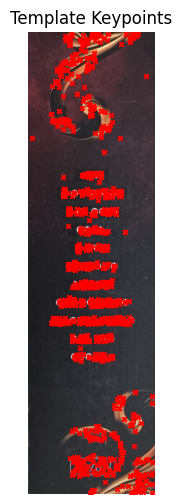

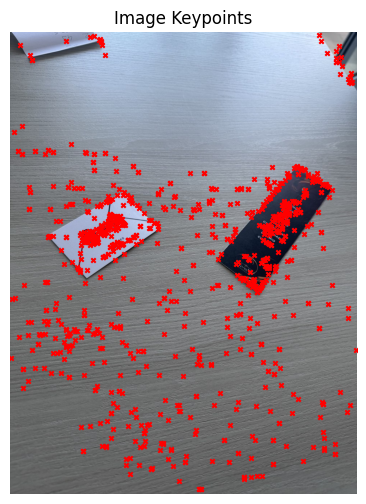

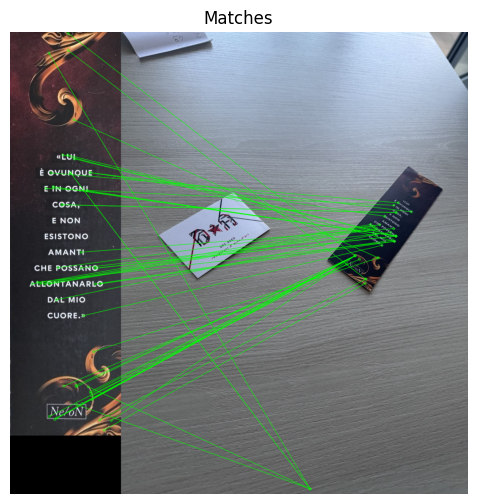

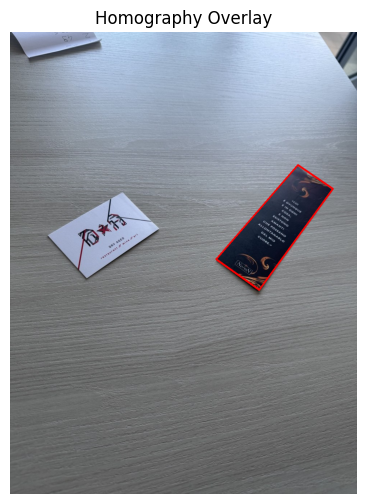

In [10]:
H, mask = template_match(template_path, scene_path, extract_method='SIFT', match_method='FLANN')

In [11]:
# Print the homography matrix
print("Homography matrix H:")
print(H)

Homography matrix H:
[[ 2.90309660e-01 -3.03345845e-01  7.96910302e+02]
 [ 2.03521747e-01  1.21531452e-01  3.68521251e+02]
 [-2.60893211e-05 -1.77334693e-04  1.00000000e+00]]


In [12]:
# Print the condition number of the homography matrix
cond_num = np.linalg.cond(H)
print(f"Condition number of H: {cond_num:.2f}")

Condition number of H: 2044691.77


In [13]:
# Recover the pose using the homography matrix and camera intrinsics
from src.geometry import recover_pose_from_homography_v2


R, t = recover_pose_from_homography_v2(H, K)

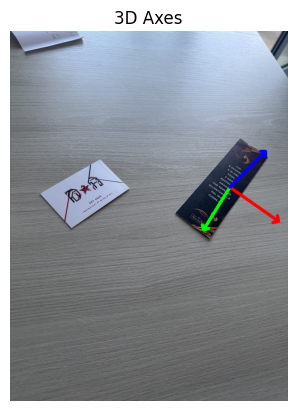

In [14]:
t_shape = template_image.shape[:2]

# Draw 3D axes
img = draw_3d_axes(scene_image, R, t, K, template_shape=t_shape)

# Plot the image with 3D axes
plt.show()
plt.imshow(img)
plt.title("3D Axes")
plt.axis('off')
plt.show()

In [15]:
# Width and height in real-world units (e.g., mm)
real_w = template.width
real_h = template.height
width = t_shape[1]
height = t_shape[0]


dist_grid = compute_distance_grid_new(
    R=R,
    t_unscaled=t,
    width=real_w,
    height=real_h,
    template_real_length=real_h,
    template_pixel_length=height
)
print(np.round(dist_grid, 2))

Scale: 0.5773502691896257
Scale factor: 0.16100178890876565
Original ||t||: 2623.0508680994913
Scaled ||t||: 1514.4191247953227
[[422.32 425.33 428.43]
 [420.71 423.73 426.85]
 [420.6  423.62 426.74]]


In [16]:
unit = data.unit
from_id = 'Camera'
to_id = template.id

distance_pred = dist_grid[1, 1]
distance_true = scene.get_distance(from_id, to_id).distance
error = np.abs(distance_pred - distance_true)
error_perc = (error / distance_true) * 100

print(f"Predicted distance: {distance_pred:.2f} {unit}")
print(f"True distance: {distance_true} {unit}")
print(f"Error: {error:.2f} {unit} - {error_perc:.2f}%")

Predicted distance: 423.73 mm
True distance: 380.0 mm
Error: 43.73 mm - 11.51%


In [17]:
# Save rotation and translation to JSON
pose_data = [{
    'R': R.tolist(),
    't': t.flatten().tolist(),
    't_size': t_shape,
}]

pose_json_path = os.path.join(project_root, 'pose.json')
with open(pose_json_path, 'w') as f:
    json.dump(pose_data, f, indent=4)
print(f"Pose saved to {pose_json_path}")

Pose saved to /home/stefano/projects/single-view-3d/pose.json
